<a href="https://colab.research.google.com/github/etietopabraham/Numerical-ODE-Solver/blob/main/Numerical_ODE_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

y(x) = is the corrected value of y at each step using the explicit Euler method.

Δyk = is the change in y at each step, computed at h *f(x,y).

Y~ucm = is the uncorrected value for y at each step.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [2]:
class ODESolver:
    """
    A class to solve ordinary differential equations (ODEs) using various numerical methods.

    Attributes:
    - f: The function representing the ODE dy/dx = f(x, y)
    - x0, y0: Initial conditions
    - h: Step size for the numerical method
    - steps: Number of steps to perform
    - x_values, y_values: Lists to store the computed x and y values
    - delta_y_values: List to store the change in y at each step
    """

    def __init__(self, f, x0, y0, h, steps):
        """Initialize the ODESolver with the ODE function, initial conditions, step size, and number of steps."""
        self.f = f
        self.x0 = x0
        self.y0 = y0
        self.h = h
        self.steps = steps
        self.x_values = [x0]
        self.y_values = [y0]
        self.delta_y_values = [0]  # No change at the initial condition

    class Method:
        """
        Nested class to define different numerical methods for solving ODEs.
        """

        @staticmethod
        def euler(x, y, h, f):
            """Compute the next y value using the Euler method."""
            return y + h * f(x, y)

        @staticmethod
        def euler_cauchy(x, y, h, f):
            """Compute the next y value using the Euler-Cauchy method."""
            y_star = y + h * f(x, y)
            return y + (h / 2) * (f(x, y) + f(x + h, y_star))

        @staticmethod
        def implicit_euler_cauchy(x, y, h, f):
            """Compute the next y value using the Implicit Euler-Cauchy method (simplified for linear f)."""
            return y + (h / 2) * (f(x, y) + f(x + h, y + h * f(x, y)))

        @staticmethod
        def rk4(x, y, h, f):
            """Compute the next y value using the fourth-order Runge-Kutta method."""
            k1 = h * f(x, y)
            k2 = h * f(x + 0.5 * h, y + 0.5 * k1)
            k3 = h * f(x + 0.5 * h, y + 0.5 * k2)
            k4 = h * f(x + h, y + k3)
            return y + (k1 + 2*k2 + 2*k3 + k4) / 6

        @staticmethod
        def adams_bashforth_2(x, y, h, f, prev_f):
            """Compute the next y value using the 2-step Adams-Bashforth method."""
            return y + (h / 2) * (3 * f(x, y) - prev_f)

    def get_delta_y(self, x, y):
        """Compute the change in y at each step."""
        return self.h * self.f(x, y)

    def solve(self, method, prev_method=None):
        """
        Solve the ODE using the specified numerical method.

        Arguments:
        - method: A function from the Method class representing the numerical method to use.
        - prev_method: Optional method to compute initial values for multistep methods.
        """
        if method == self.Method.adams_bashforth_2 and prev_method:
            for _ in range(1):  # For 2-step Adams-Bashforth, we need one additional starting value
                delta_y = self.get_delta_y(self.x0, self.y0)
                self.y0 = prev_method(self.x0, self.y0, self.h, self.f)
                self.x0 += self.h
                self.x_values.append(self.x0)
                self.y_values.append(self.y0)
                self.delta_y_values.append(delta_y)

        for _ in range(self.steps - (1 if method == self.Method.adams_bashforth_2 else 0)):
            delta_y = self.get_delta_y(self.x0, self.y0)

            # Handle special case for Adams-Bashforth
            if method == self.Method.adams_bashforth_2:
                prev_f = self.f(self.x_values[-2], self.y_values[-2])
                self.y0 = method(self.x0, self.y0, self.h, self.f, prev_f)
            else:
                self.y0 = method(self.x0, self.y0, self.h, self.f)

            self.x0 += self.h
            self.x_values.append(self.x0)
            self.y_values.append(self.y0)
            self.delta_y_values.append(delta_y)

    def get_results(self):
        """Return the results as a dataframe."""
        return pd.DataFrame({
            'x': self.x_values,
            'y(x)': self.y_values,
            'Δyk': self.delta_y_values
        })


In [3]:
def main(method, prev_method=None):
    """
    Main function to use the ODESolver class to solve the differential equation dy/dx = (y + x)^2.

    Arguments:
    - method: A function from the ODESolver.Method class representing the numerical method to use.
    - prev_method: Optional method to compute initial values for multistep methods.

    Returns:
    - df: A DataFrame containing the x values, y(x) values, and Δyk values.
    """

    # Define the ODE function
    def f(x, y):
        """Function representing the ODE dy/dx = (y + x)^2."""
        return (y + x)**2

    # Initialize and solve the ODE using the specified method
    x0 = 0
    y0 = 0
    h = 0.1
    steps = int(0.5 / h)

    solver = ODESolver(f, x0, y0, h, steps)
    solver.solve(method, prev_method)
    df = solver.get_results()

    return df

# Testing the updated class and main function
df_adams_bashforth = main(ODESolver.Method.adams_bashforth_2, ODESolver.Method.rk4)
df_euler = main(ODESolver.Method.euler)
df_euler_cauchy = main(ODESolver.Method.euler_cauchy)
df_implicit_euler_cauchy = main(ODESolver.Method.implicit_euler_cauchy)
df_rk4 = main(ODESolver.Method.rk4)



In [4]:
# Define the exact solution
def exact_solution(x):
    return np.tan(x) - x

# Generate x values and compute the exact solution values
x_values = np.arange(0, 0.5 + 0.1, 0.1)  # x values from 0 to 0.5 with a step of 0.1
exact_y_values = exact_solution(x_values)

In [5]:
# Combine the results in one table
combined_df = pd.DataFrame({
    'x': x_values,
    'Exact Solution': exact_y_values,
    'Euler': df_euler['y(x)'],
    'Euler-Cauchy': df_euler_cauchy['y(x)'],
    'Implicit Euler-Cauchy': df_implicit_euler_cauchy['y(x)'],
    'RK4': df_rk4['y(x)'],
    'Adams-Bashforth': df_adams_bashforth['y(x)']
})

combined_df

,x,Exact Solution,Euler,Euler-Cauchy,Implicit Euler-Cauchy,RK4,Adams-Bashforth
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,0.000335,0.000000,0.000500,0.000500,0.000335,0.000335
2,0.2,0.002710,0.001000,0.003035,0.003035,0.002710,0.001845
3,0.3,0.009336,0.005040,0.009814,0.009814,0.009336,0.007452
4,0.4,0.022793,0.014345,0.023408,0.023408,0.022793,0.019594
5,0.5,0.046302,0.031513,0.047024,0.047024,0.046302,0.041277


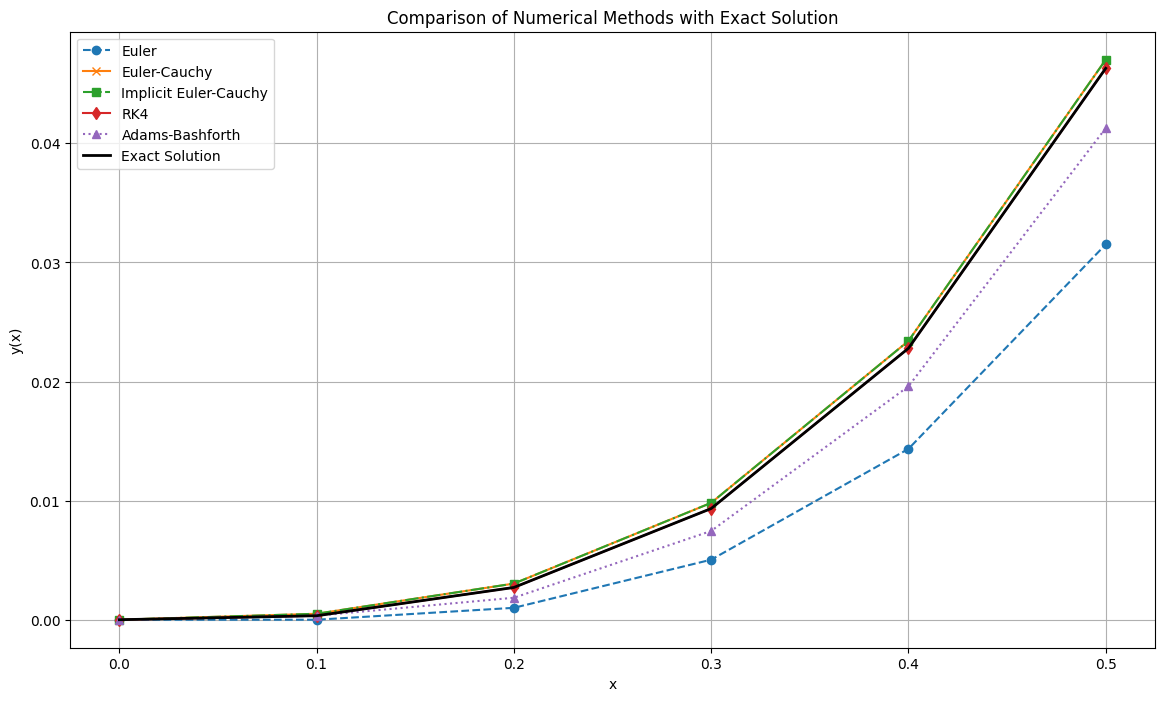

In [6]:
# Plot the results for all methods and the exact solution
plt.figure(figsize=(14, 8))

# Numerical methods
plt.plot(df_euler['x'], df_euler['y(x)'], label='Euler', marker='o', linestyle='--')
plt.plot(df_euler_cauchy['x'], df_euler_cauchy['y(x)'], label='Euler-Cauchy', marker='x', linestyle='-')
plt.plot(df_implicit_euler_cauchy['x'], df_implicit_euler_cauchy['y(x)'], label='Implicit Euler-Cauchy', marker='s', linestyle='-.')
plt.plot(df_rk4['x'], df_rk4['y(x)'], label='RK4', marker='d', linestyle='-')
plt.plot(df_adams_bashforth['x'], df_adams_bashforth['y(x)'], label='Adams-Bashforth', marker='^', linestyle=':')

# Exact solution
plt.plot(x_values, exact_y_values, label='Exact Solution', color='black', linewidth=2)

plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Comparison of Numerical Methods with Exact Solution')
plt.legend()
plt.grid(True)
plt.show()
